In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df=pd.read_csv(r'../input/customer-sales-transactions-of-retail-store/Customer_Sales_Transactional_Data_CSV.txt', encoding='cp1251', sep =',')
df.head()

## Available data allows us RFM-segmentation.
## Underlying the RFM segmentation technique is the idea that marketers can gain an extensive understanding of their customers by analyzing three quantifiable factors. These are:

### 1. Recency: How much time has elapsed since a customer’s last activity or transaction with the brand? Activity is usually a purchase, although variations are sometimes used, e.g., the last visit to a website or use of a mobile app. In most cases, the more recently a customer has interacted or transacted with a brand, the more likely that customer will be responsive to communications from the brand.
### 2. Frequency: How often has a customer transacted or interacted with the brand during a particular period of time? Clearly, customers with frequent activities are more engaged, and probably more loyal, than customers who rarely do so. And one-time-only customers are in a class of their own.
### 3.Monetary: Also referred to as “monetary value,” this factor reflects how much a customer has spent with the brand during a particular period of time. Big spenders should usually be treated differently than customers who spend little. Looking at monetary divided by frequency indicates the average purchase amount – an important secondary factor to consider when segmenting customers.


#### Here we work prepare our data for analisys

In [ ]:
df.rename(columns={'SALES_dATE': 'sale_date', 'CUSTOMER_ID': 'customer_id', 'SALES_AMOUNT':'sale_amount'}, inplace=True)
df.head()

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum()

In [ ]:
df['sale_date']= pd.to_datetime(df['sale_date'])

## Let's see what period of time we have

In [ ]:
print(df.sale_date.max())
print(df.sale_date.min())

### Creating a dataset where we collect data for each indicator RFM. Start with writing all ids of customers

In [ ]:
cus_df=pd.DataFrame(df['customer_id'].unique())
cus_df.columns = ['customer_id']
cus_df

### As Recency is how many days have passed since the last purchase, let's find date of the last purchase for every customer

In [ ]:
max_purchase = df.groupby('customer_id').sale_date.max().reset_index()
max_purchase.columns = ['customer_id','MaxPurchaseDate']
max_purchase

### The reporting date will be the latest date in the dataset

In [ ]:
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
max_purchase

In [ ]:
cus_df = pd.merge(cus_df, max_purchase[['customer_id','Recency']], on='customer_id')

cus_df.head(10)

### Clustering will be carried out using the Kmean algorithm. Find the optimal number of clusters in Kmean. Diagramm shows, that optimal amount of clusters is 4

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
sse={}
recency = cus_df[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of cluster")
plt.show()

### Creating a special function, which arranges clusters from Random to ascending or descending order

In [ ]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


### Counting the number of purchases for each customer for Frequency indicator

In [ ]:
frequency = df.groupby('customer_id').sale_date.count().reset_index()
frequency.columns = ['customer_id','Frequency']

#add this data to our main dataframe
cus_df = pd.merge(cus_df, frequency, on='customer_id')
cus_df

### Counting the amount paid by each buyer for all his purchases

In [ ]:
monetary = df.groupby('customer_id').sale_amount.sum().reset_index()
monetary.columns = ['customer_id','Monetary']
cus_df = pd.merge(cus_df, monetary, on='customer_id')
cus_df

### Creating clusters for each indicator

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(cus_df[['Recency']])
cus_df['RecencyCluster'] = kmeans.predict(cus_df[['Recency']])
cus_df = order_cluster('RecencyCluster', 'Recency',cus_df,True)
cus_df['FrequencyCluster'] = kmeans.predict(cus_df[['Frequency']])
cus_df = order_cluster('FrequencyCluster', 'Frequency',cus_df,False)
cus_df['MonetaryCluster'] = kmeans.predict(cus_df[['Monetary']])
cus_df = order_cluster('MonetaryCluster', 'Monetary',cus_df,False)
cus_df

In [ ]:
print(cus_df.groupby('RecencyCluster')['Recency'].describe())
print(cus_df.groupby('FrequencyCluster')['Frequency'].describe())
print(cus_df.groupby('MonetaryCluster')['Monetary'].describe())

### Overall Score is a collective value of the cluster, which is obtained from the sum of the cluster number for each indicator

In [ ]:
cus_df['OverallScore'] = cus_df['RecencyCluster'] + cus_df['FrequencyCluster'] + cus_df['MonetaryCluster']
cus_df.sort_values('OverallScore')

### Describing clusters

In [ ]:
cus_df.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

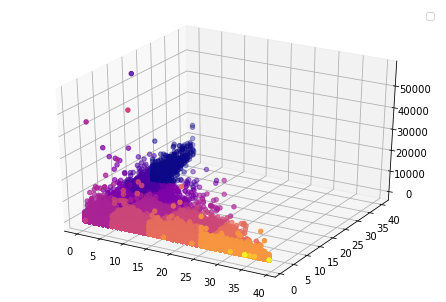

In [28]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(cus_df['Recency'], cus_df['Frequency'], cus_df['Monetary'], c=cus_df['OverallScore'], cmap="plasma" )
pyplot.legend()
pyplot.show()